Process for CVQC

In [1]:
import csv
import time
import random
import numpy as np
import networkx as nx
import strawberryfields as sf
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from strawberryfields import ops
from itertools import combinations
from strawberryfields.apps import data, sample, subgraph, plot, qchem
from strawberryfields.apps.similarity import feature_vector_orbits_sampling
from strawberryfields.utils import random_interferometer

Step1: Mapping

In [2]:
# function that take a raw matrix and k (number of columns) and n (the nth number you want to compare) value in, return the best k columns
def find_best_k_combination(matrix, k, n):
    # get all possible combination
    num_columns = matrix.shape[1]
    column_combinations = combinations(range(num_columns), k)
        
#     column_combinations = get_column_combinations(matrix, k)
    
    strength = []
    Combination = []

    for combination in column_combinations:
        Combination.append(combination)
        selected_columns = matrix[:, combination]
        # calculate the row abs square sum
        row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
        # make it decrease
        sorted_indices = np.argsort(row_sums)[::-1]
        sorted_row_sums = row_sums[sorted_indices]
        val = sorted_row_sums[n-1]
        strength.append(val)

    largest_value = np.max(strength)
    largest_index = np.argmax(strength)

    # find the best combination
    best_combination = Combination[largest_index]
    best_selected_columns = matrix[:, best_combination]

    return best_selected_columns

In [3]:
# final function, recieve the original matrix and a list of len, also n (the nth number you want to compare), return the permuted matrix
# U = row_per_matrix*U'*col_per_matrix
def mapping(U, len_list, n):
    
    M, N = U.shape
    total_len = sum(len_list)
    assert N == total_len
    
    # copy U
    U_t = U.copy()
#     print(U)
    
    # new column permutation
    for i, length in enumerate(len_list):
        if i<len(len_list)-1:
            U_new = U_t[:,:length].copy()
#             print("i:", i)
            # calculate the row abs square sum
            row_sums = np.sum(np.abs(U_new) ** 2, axis=1)
            U_new_update = U_new.copy()
            # iterate remain column
            for j in range(np.sum(len_list[i+1:])):
#                 print("j:", j)
                for k in range(length):
#                     print("k:", k)
                    U_new_update_k = U_new_update[:,k].copy()
                    U_new_update[:,k] = U_t[:,length+j].copy()
                    # calculate the row abs square sum
                    row_sums_update = np.sum(np.abs(U_new_update) ** 2, axis=1)
                
                    if np.sort(row_sums_update)[::-1][n-1] > np.sort(row_sums)[::-1][n-1]:
#                     row_sums_update[n-1] > row_sums[n-1]:
                        U_new = U_new_update.copy()
                        U_t[:,length+j] = U_new_update_k.copy()
                        U_t[:,:length] = U_new.copy()
                        row_sums = row_sums_update
                    else:
                        U_new_update = U_new.copy()

            
            # add U_new to U_per
            if i==0:
                U_per = U_new.copy()
            elif i==len(len_list)-2:
                U_per = np.hstack((U_per, U_t)).copy()
            else:
                U_per = np.hstack((U_per, U_new)).copy()

            
            # drop U_new from U_t
            U_t = U_t[:,length:].copy()
        
                    

#     for i, length in enumerate(len_list):
#         U_new = find_best_k_combination(U_t, length, n)
        
#         # Find column indices in the larger matrix corresponding to the smaller matrix
#         selected_columns = []
#         for col in range(U_new.shape[1]):
#             for j in range(U_t.shape[1]):
#                 if np.array_equal(U_new[:, col], U_t[:, j]):
#                     selected_columns.append(j)
#                     break

#         # drop U_new from U_t
#         U_t = np.delete(U_t, selected_columns, axis=1)
        
#         # add U_new to U_per
#         if i==0:
#             U_per = U_new
#         else:
#             U_per = np.hstack((U_per, U_new))
      
      
    # find the permutation from U_per to U
    col_permutation = []
    for col in range(U_per.shape[1]):
        for i in range(U.shape[1]):
            if np.array_equal(U_per[:, col], U[:, i]):
                col_permutation.append(i)
                break
                
    # find the columns permutation matrix
    col_per_matrix = np.zeros((N, N))
    for i in range(N):
        col_per_matrix[col_permutation[i], i] = 1
        


    # calculate the sum of first len for U_per
    selected_columns = U_per[:, :len_list[0]] 
    # calculate the row abs square sum
    row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
    
    # decide the row rotation
    sorted_indices = np.argsort(row_sums)
    U_per_new = U_per[sorted_indices]
    
    # Find row permutation
    row_permutation = []
    for row in range(U_per_new.shape[0]):
        for i in range(U_per.shape[0]):
            if np.array_equal(U_per_new[row, :], U_per[i, :]):
                row_permutation.append(i)
                break
                
    # find the rows permutation matrix
    row_per_matrix = np.zeros((M, M))
    for i in range(M):
        row_per_matrix[i, row_permutation[i]] = 1
        
    
    U_final = U_per_new
    
    # U_final = U_per, out put U_final and the permutation
    return U_final, col_per_matrix.T, row_per_matrix.T

Step2: Matrix Decomposition

In [4]:
# Define the left eliminate equations
def left_equations(variables,parameters):
    theta, phi = variables
    a_r, a_i, b_r, b_i = parameters
    eq1 = a_r * np.cos(phi) * np.cos(theta) + a_i * np.sin(phi) * np.cos(theta) - b_r * np.sin(theta)
    eq2 = a_i * np.cos(phi) * np.cos(theta) - a_r * np.sin(phi) * np.cos(theta) - b_i * np.sin(theta)
    return [eq1, eq2]

# function of left elimination
def left_elimination(a,b):
    a_r = np.real(a)
    a_i = np.imag(a)
    b_r = np.real(b)
    b_i = np.imag(b)
    
    # Solve the system of equations
    initial_guess = [0, 0]  # Initial guess for the variables
    parameters = [a_r, a_i, b_r, b_i]
    raw_solution = fsolve(left_equations, initial_guess, args=(parameters,))
    
    
    if np.abs(a_r) < 1e-8 and np.abs(b_i) < 1e-8:
            raw_solution = [np.arctan(a_i/b_r), np.pi/2]
        
    if np.abs(a_i) < 1e-8 and np.abs(b_r) < 1e-8:
            raw_solution = [np.arctan(-a_r/b_i), np.pi/2]
            
            
    if np.abs(b_r) < 1e-8 and np.abs(b_i) < 1e-8:
            raw_solution = [np.pi/2, 0]
    
    
    normalized_solution = [angle % (2 * np.pi) for angle in raw_solution]
    solution = []
    for angle in normalized_solution:
        if angle < np.pi:
            solution.append(angle)
        else:
            solution.append(angle-2*np.pi)

    # Print the solution
#     print("Solution:", solution)
    return solution

In [5]:
# Define the right eliminate equations
def right_equations(variables,parameters):
    theta, phi = variables
    a_r, a_i, b_r, b_i = parameters
    eq1 = a_r * np.cos(phi) * np.sin(theta) + a_i * np.sin(phi) * np.sin(theta) + b_r * np.cos(theta)
    eq2 = a_i * np.cos(phi) * np.sin(theta) - a_r * np.sin(phi) * np.sin(theta) + b_i * np.cos(theta)
    return [eq1, eq2]

# function of right elimination
def right_elimination(a,b):
    a_r = np.real(a)
    a_i = np.imag(a)
    b_r = np.real(b)
    b_i = np.imag(b)
    
    # Solve the system of equations
    initial_guess = [0, 0]  # Initial guess for the variables
    parameters = [a_r, a_i, b_r, b_i]
    raw_solution = fsolve(right_equations, initial_guess, args=(parameters,))
    
    if np.abs(a_r) < 1e-8 and np.abs(b_i) < 1e-8:
        raw_solution = [np.arctan(-b_r/a_i), np.pi/2]
        
    if np.abs(a_i) < 1e-8 and np.abs(b_r) < 1e-8:
        raw_solution = [np.arctan(b_i/a_r), np.pi/2]
        
    if np.abs(a_r) < 1e-8 and np.abs(a_i) < 1e-8:
        raw_solution = [np.pi/2, 0]
    
    normalized_solution = [angle % (2 * np.pi) for angle in raw_solution]
    solution = []
    for angle in normalized_solution:
        if angle < np.pi:
            solution.append(angle)
        else:
            solution.append(angle-2*np.pi)

    # Print the solution
#     print("Solution:", solution)
    return solution

In [6]:
# give rotation matrix with idx_1 < idx_2
def rotation(theta, phi, n, idx_1, idx_2):
    I = np.eye(n, dtype=complex)
    I[idx_1,idx_1] = np.cos(theta)*(np.cos(phi)-np.sin(phi)*1j)
    I[idx_1,idx_2] = np.sin(theta)*(np.cos(phi)-np.sin(phi)*1j)
    I[idx_2,idx_1] = -np.sin(theta)
    I[idx_2,idx_2] = np.cos(theta)
    
    return I

In [7]:
# matrix permutation
def permutation(U):
    
    rows, columns = U.shape
    assert(rows==columns)
    
    # create the permutation matrix
    Permutation = np.zeros([rows,columns])
    
    diag_U = np.eye(rows, dtype=complex)
    
    indices = np.nonzero(U)
    row_info = indices[0]
    col_info = indices[1]
    
    for i in range(rows):
        col = col_info[i]
        row = row_info[i]
        diag_U[col,:] = U[row,:]
        Permutation[col,row] = 1
        
    return diag_U, Permutation.T

In [8]:
def phase(x):
    x_r = np.real(x)
    x_i = np.imag(x)
    
    raw_phi = np.arccos(x_r)
    if x_i > 0:
        t_phi = raw_phi
    else:
        t_phi = -raw_phi
        
    normalized_solution = t_phi % (2 * np.pi)
    if normalized_solution > np.pi:
        normalized_solution = normalized_solution-2*np.pi

    return normalized_solution

In [9]:
# the all_list tell the decomposition order
# [[1,2], [2,3], [3,4]] means first use 2 eliminate 1, then use 3 eliminate 2, then use 4 eliminate 3
def U_decompose_plus(U, all_list):
    
    # pick up a machine precision
    threshold = 1e-8
    
    # get the shape of unitary
    rows, columns = U.shape
    assert(rows==columns)
    
    # create the rotation record matrix, the first row for theta, the second row for phi 
    # third row for low index, forth row for high index
    Theta = []
    Phi = []
    Low_idx = []
    High_idx = []
    
    # create the diagonal record matrix
    Diag = []
    

    for i in range(rows-1, 0, -1):
        list_i = all_list[i-1]
        row = U[i, :]
        
        for j in range(i):
            pair = list_i[j]
            
            
            # a is the number to be eliminated, b is the number to eliminate the previous one
            a = row[pair[0]]
            b = row[pair[1]]
            
            
#             if i % 3 != 0:
#                 if j == i-1:
#                     a = row[pair[1]]
#                     b = row[pair[0]]
                
                
            # choose the elimination method by position
            if pair[0] < pair[1]: 
                theta, phi = left_elimination(a,b)

                # write down the parameter
                Theta.append(theta)
                Phi.append(phi)
                Low_idx.append(pair[0])
                High_idx.append(pair[1])

                # create the rotation
                r = rotation(theta, phi, rows, pair[0], pair[1])
        

                # update Unitary
                U = np.dot(U, r)
                U= np.where(np.abs(U) < threshold, 0, U)

            else:
                theta, phi = right_elimination(b,a)

                # write down the parameter
                Theta.append(theta)
                Phi.append(phi)
                Low_idx.append(pair[1])
                High_idx.append(pair[0])

                # create the rotation
                r = rotation(theta, phi, rows, pair[1], pair[0])

                # update Unitary
                U = np.dot(U, r)
                U= np.where(np.abs(U) < threshold, 0, U)

            row = U[i, :]
            
#             if (np.count_nonzero(row) == 1):
            if j == i-1:
                entry = U[i, pair[1]]
                U[:, pair[1]] = 0
                U[i, :] = 0
                U[i, pair[1]] = entry
                flag = 0
    
    # do the permutation, and record
    U, Permutation = permutation(U)
    
    # find the phase shift
    for i in range(rows):
        x = U[i,i]/np.abs(U[i,i])
        phi_x = phase(x)
        Diag.append(phi_x)
        U[i,i] = U[i,i]*(np.cos(phi_x)-np.sin(phi_x)*1j)
    
    
    return U, Theta, Phi, Low_idx, High_idx, Diag, Permutation

Step3: Drift Method

In [10]:
# Step1 probability
def calculate_probability_sequence(angles, threshold, N):
    abs_angles = np.abs(angles)
    angles1 = abs_angles/(threshold)
    angles2 = angles1**N
    total_magnitude = np.sum(angles2)
    probabilities = angles2 / total_magnitude
    return probabilities

In [11]:
# sequence is the origianl angel sequence, probability is calculate using calculate_probability_sequence(angles), percentage is the proportion you want to preserve
def pick_entries_with_indices(sequence, probabilities, proportion):
    
    N = len(sequence)
    num_entries = np.floor(N*proportion).astype(int)
    
    idx_sequence = np.arange(N).astype(int)
    
    if np.count_nonzero(probabilities) < num_entries:
        num_entries = np.count_nonzero(probabilities)
    
    picked_indices = np.random.choice(idx_sequence, size=num_entries, replace=False, p=probabilities)
    picked_entries = [sequence[index] for index in picked_indices]

    # Sort the picked entries and indices based on the indices
    picked_entries, picked_indices = zip(*sorted(zip(picked_entries, picked_indices), key=lambda x: x[1]))
    
    modified_sequence = [entry if index in picked_indices else 0 for index, entry in enumerate(sequence)]

    return modified_sequence

Step4: Matric Reconstruction

In [12]:
def make_entries_zero(Array, threshold):
    array = Array.copy()
    for i in range(len(array)):
        if np.abs(array[i]) < threshold:
            array[i] = 0
    return array

In [13]:
# give rotation matrix with idx_1 < idx_2
def reconstruct_rotation(theta, phi, n, idx_1, idx_2):
    I = np.eye(n, dtype=complex)
    I[idx_1,idx_1] = np.cos(theta)*(np.cos(phi)+np.sin(phi)*1j)
    I[idx_1,idx_2] = -np.sin(theta)
    I[idx_2,idx_1] = np.sin(theta)*(np.cos(phi)+np.sin(phi)*1j)
    I[idx_2,idx_2] = np.cos(theta)
    
    return I

In [14]:
def matrix_reconstruct(Theta, Phi, Low_idx, High_idx, Diag, Permutation, N):
    
    M = len(Theta)
    
    per_theta = (len([x for x in Theta if np.abs(x) == 0]) / len(Theta)) * 100
#     print("theta reduce")
#     print(per_theta)
    
    per_phi = (len([x for x in Phi if np.abs(x) == 0]) / len(Phi)) * 100
#     print("phi reduce")
#     print(per_phi)

#     new_theta = Theta
#     new_phi = Phi
    
    V = np.eye(N, dtype=complex)
    
    # rotation
    for i in range(M):
        r = reconstruct_rotation(Theta[i], Phi[i], N, Low_idx[i], High_idx[i])
        V = np.dot(r, V)
        
    # phase shift
    for i in range(N):
        V[i,:] = V[i,:]*(np.cos(Diag[i])+np.sin(Diag[i])*1j)
        
    # permutation
    V = np.dot(Permutation, V)
    
    return V

Accuracy

In [15]:
# function to calculate the approximation accuracy
def accuracy(U,U_app):
    I = np.dot(U,np.conjugate(U_app).transpose())
    N, N = I.shape
    acc = np.trace(I)/N
    return acc

In [16]:
def unitary_accuracy(M, U1, dec_list, maps, len_list, n, proportion1, th, N):
    
    N, N = U1.shape
    
    # mapping
    if maps:
        U1_map, col_per_matrix, row_per_matrix = mapping(U1, len_list, n)
    else:
        U1_map = U1
        
    # get the decomposition information of U1
    _, Theta1, Phi1, Low_idx1, High_idx1, Diag1, Permutation1 = U_decompose_plus(U1_map, dec_list)
    
    # modify Theta
    Theta_prob1 = calculate_probability_sequence(Theta1, th, N)
    
    k = 0
    acc1 = []
    while k < M:

        # get the new Theta from the probability distribution
        new_Theta1 = pick_entries_with_indices(Theta1, Theta_prob1, proportion1)
        new_Phi1 = Phi1
        
        # reconstruction of U2 using new angel
        U1_map_app = matrix_reconstruct(new_Theta1, new_Phi1, Low_idx1, High_idx1, Diag1, Permutation1, N)
        # approximation accuracy
        acc1_t = accuracy(U1_map,U1_map_app)
        acc1.append(acc1_t)
        
        k = k+1
        
    acc1_mean = np.mean(acc1)
    print("mean accuracy for U1:", acc1_mean)    

Reduce counting

In [17]:
def count_numbers_less_than(numbers, threshold):
    count = 0
    for number in numbers:
        if np.abs(number) < threshold:
            count += 1
    return count

Convert sample to nodes

In [18]:
# convert sample to nodes
def convert_binary_to_nodes(binary_array):
    nodes_array = []

    for i in range(len(binary_array)):
        if binary_array[i] == 1:
            nodes_array.append(i)

    return nodes_array

Step5: Sampling dense subgraph

In [19]:
# define the sampleing function
# G is the graph
# G_dense_dic contains the information that tells the densest value of k nodes, k from 1 to N
# M is the total sampling numbers
# A is the adjacency matrix
# dec_list: a list give the decomposition order  
# mapping: "on" or "off", coreesponding to 1 or 0
# len_list: a list for mapping
# n: a compare number for mapping
# all_modes: (q[0], ..., q[N-1])
# proportion: 0~1 for U2
# loss is the photon number loss
# qdrift_kind: 0: defualt, 1:cut
def graph_sampling_plus(G, G_dense_dic, M, S, U, dec_list, maps, len_list, n, proportion, th, N, loss, kind):
    
#     # takagi decomposition to get Squeezing and Unitary
#     S, U = sf.decompositions.takagi(A)
    
    N, N = U.shape
    
    S_max = np.max(S)
    S = S/(S_max+0.5)
    S = np.arctanh(S)
    
    # mapping
    if maps:
        U_map, col_per_matrix, row_per_matrix = mapping(U, len_list, n)
    else:
        U_map = U
        col_per_matrix = np.eye(N)
        row_per_matrix = np.eye(N)
    
    # get the decomposition information of U
    _, Theta, Phi, Low_idx, High_idx, Diag, Permutation = U_decompose_plus(U_map, dec_list)
    
    # modify Theta
    Theta_prob = calculate_probability_sequence(Theta, th, N)
    
    
    
    k = 0
    sample = []
    acc = []
    confusion_list = []
    clique = 0
    while k < M:
#         print(k)
#         if k % 1000 == 0:
#             print(k)
        
        # get the new Theta from the probability distribution
        new_Theta = pick_entries_with_indices(Theta, Theta_prob, proportion)
#         new_Theta = Theta
        new_Phi = Phi
        
        # reconstruction of U using new angel
        U_map_app = matrix_reconstruct(new_Theta, new_Phi, Low_idx, High_idx, Diag, Permutation, N)
        # approximation accuracy
        acc_t = accuracy(U_map,U_map_app)
        acc.append(acc_t)
        
        
        # construct the circuit
        prog = sf.Program(N)
        eng = sf.Engine('gaussian')
        with prog.context as q:
            
            # r squeezing
            for i, s in enumerate(S):
                ops.Sgate(s) | q[i]
            
            # mapping's column transformation
            ops.Interferometer(col_per_matrix) | (q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23])
            
            
            # interferometer U
            for i in range(len(new_Theta)):
                ops.Rgate(new_Phi[i])       | q[Low_idx[i]]
                ops.BSgate(new_Theta[i], 0) | (q[Low_idx[i]], q[High_idx[i]])
                if np.abs(new_Theta[i]) > 0:
                    ops.LossChannel(loss) | q[Low_idx[i]]
                    ops.LossChannel(loss) | q[High_idx[i]]
                
            for i in range(N):
                ops.Rgate(Diag[i])       | q[i]
                
                
            # mapping's row transformation
            ops.Interferometer(row_per_matrix) | (q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23])
            
            
            # measurement
            ops.MeasureThreshold() | q
            

        
        results = eng.run(prog, shots=1)
        sample_t = results.samples
        sample.append(sample_t[0])
#         print(sample_t)
        
        # change the sample to the right form
        sample_sub_t = convert_binary_to_nodes(sample_t[0])
        sample_sub_t = [str(num) for num in sample_sub_t]
#         print(sample_sub_t)
        
        # calculate is this sample_sub's desity  
        if (len(sample_sub_t)>=10):
            subgraph = G.subgraph(sample_sub_t)
            density = calculate_density(subgraph)
#             density = subgraph.search([sample_sub_t], G, len(sample_sub_t), len(sample_sub_t), max_count=1)[len(sample_sub_t)][0][0]
#             print(density)
        else: 
            density = 0
        
        # find the subgraph size
        size_t = len(sample_sub_t)
#         print(size_t)

        # find out if it is the densest subgraph in this size
        if density >= G_dense_dic[size_t]-1e-5:
            confusion_list.append(1)
            print(kind, size_t)
            if density == 1:
                clique = clique + 1
#             print(density)
#             print(size_t)
        else: 
            confusion_list.append(0)
        
        k = k+1
        
    # calculate the frequency that successfully find the dense sub graph
    
    acc_mean = np.mean(acc)
#     print("mean accuracy for U:", acc_mean)
    
    metric = confusion_list.count(1)/len(confusion_list)
#     print("successfully find dense subgraph:", metric)
#     print(clique)

    # manipulate the samples
    zero = np.zeros(N)
    for i in range(len(sample)):
        sample[i] = np.concatenate((sample[i], zero))
    sample_list = []
    for a in sample:
        b = list(a)
        c = [int(num) for num in b]
        sample_list.append(c)
    
        
    return sample_list, metric

Benchmark for dense subgraph: 30 nodes with edges connected at a probability 0.875

In [20]:
def generate_random_graph(nodes, probability):
    G = nx.Graph()
    G.add_nodes_from(nodes)

    for i in nodes:
        for j in nodes:
            if i != j and random.random() < probability:
                G.add_edge(i, j)

    return G

In [21]:
def calculate_density(subgraph):
    num_nodes = len(subgraph.nodes())
    num_edges = len(subgraph.edges())
    return 2 * num_edges / (num_nodes * (num_nodes - 1))

In [22]:
def find_highest_density_subgraph(G):
    
    highest_density = 0.0
    highest_density_subgraph = None
    N = len(G)
    
    density_iter = [1.0, 1.0]
    for k_nodes in range(2, N+1):  # Iterate over all possible subgraph sizes
#         print(k_nodes)
        subgraphs = combinations(G.nodes(), k_nodes)  # Generate all combinations of nodes
        highest_density = 0
        
#         highest_density = 0.5
        
        for nodes in subgraphs:
            subgraph = G.subgraph(nodes)  # Create a subgraph from the selected nodes
            density = calculate_density(subgraph)
            if density > highest_density:
                highest_density = density
                
        print(highest_density)
        density_iter.append(highest_density)
        
#     density_iter.append(1.0)

    return density_iter

In [23]:
# give a dictionary that contains the information that the densest density for k nodes
def create_density_dictionary(density_iter):
    density_dict = {}
    for position, density in enumerate(density_iter):
        density_dict[position] = density
    return density_dict

In [24]:
# # Generate G
# G = generate_random_graph(range(24), 0.78)

In [25]:
# # Write the graph as an adjacency list
# nx.write_adjlist(G, "graph.adjlist")

# Read the graph from the adjacency list
G = nx.read_adjlist("graph.adjlist")

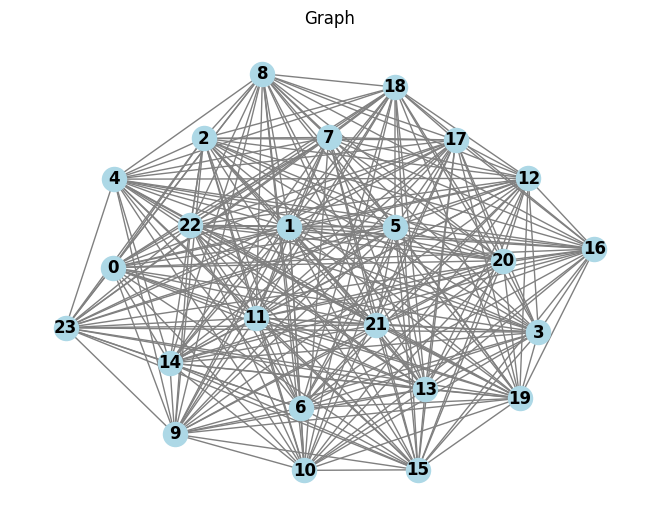

In [26]:
pos = nx.spring_layout(G)  # Layout algorithm for node positioning
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')

plt.title("Graph")
plt.show()

In [27]:
# Obtain the adjacency matrix of the graph G
A = nx.to_numpy_array(G)

In [28]:
S, U = sf.decompositions.takagi(A)

In [29]:
S, U = sf.decompositions.takagi(A)
S_max = np.max(S)
S = S/(S_max+0.5)

In [30]:
n = 0
for s in S:
    n = n+s**2/(1-s**2)
print(n)

21.941677886552075


In [31]:
S, U = sf.decompositions.takagi(A)

In [32]:
calculate_density(G)

0.9601449275362319

Calculate the information of this graph

In [33]:
# function that find the densest subgraph in graph G of all size k
# density_iter = find_highest_density_subgraph(G)

In [34]:
density_iter = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993464, 0.988304, 0.984210, 0.976190, 0.969696, 0.964426, 0.960144]

In [35]:
density_dict = create_density_dictionary(density_iter)

In [36]:
print(density_dict)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 0.993464, 19: 0.988304, 20: 0.98421, 21: 0.97619, 22: 0.969696, 23: 0.964426, 24: 0.960144}


dec_list1: 1D

In [37]:
list_order = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [10,11], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [19,20], [20,21], [21,22], [22,23]]
dec_list1 = [list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order]

len_list1: 1D

In [38]:
len_list1 = [24]

dec_list2: 2D

In [39]:
list_order23 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8], [22,8], [8,23]]
list_order22 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8], [8,22]]
list_order21 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8]]
list_order20 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [7,21]]
list_order19 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [7,20]]
list_order18 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7]]
list_order17 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [6,19]]
list_order16 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [6,18]]
list_order15 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6]]
list_order14 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [5,17]]
list_order13 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [5,16]]
list_order12 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5]]
list_order11 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [4,13]]
list_order10 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [4,14], [14,15]]
list_order9 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [4,14]]
list_order8 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4]]
list_order7 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [3,12]]
list_order6 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3]]
list_order5 = [[0,1], [9,1], [10,1], [1,2], [2,11]]
list_order4 = [[0,1], [9,1], [10,1], [1,2]]
list_order3 = [[0,1], [9,1], [1,10]]
list_order2 = [[0,1], [1,9]]
list_order1 = [[0,1]]


dec_list2 = [list_order1, list_order2, list_order3, list_order4, list_order5, list_order6, list_order7, list_order8, list_order9, list_order10, list_order11, list_order12, list_order13, list_order14, list_order15, list_order16, list_order17, list_order18, list_order19, list_order20, list_order21, list_order22, list_order23]

len_list2: 2D

In [40]:
len_list2 = [9,1,1,1,1,2,1,1,1,1,1,1,1,1,1]

Base Experiment

In [41]:
start_time = time.time()
sample_list_base, acc_base = graph_sampling_plus(G, density_dict, 20000, S, U, dec_list1, 0, len_list1, 12, 1, 1, 1, 1, 'base:')
end_time = time.time()
execution_time_base = end_time - start_time

C:\Windows\Temp\ipykernel_36844\2223956829.py:23: RuntimeWarning: divide by zero encountered in double_scalars
C:\Windows\Temp\ipykernel_36844\2223956829.py:26: RuntimeWarning: divide by zero encountered in double_scalars
C:\Windows\Temp\ipykernel_36844\2223956829.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Windows\Temp\ipykernel_36844\2223956829.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\周\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [42]:
# create path for sample_base
path_sample_base = 'sample_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_list_base)

In [43]:
# create path for acc_base
path_acc_base = 'acc_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_acc_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([acc_base])

In [44]:
# create path for time_base
path_time_base = 'time_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_time_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([execution_time_base])